In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import utils

In [3]:
# Количество классов изображений
nb_classes = 10
# Названия классов из набора данных CIFAR-10
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']
# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train10 = utils.to_categorical(y_train, nb_classes)
y_test10 = utils.to_categorical(y_test, nb_classes)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

170498071/170498071 [==============================] - 13s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [31]:
#Загрузка предварительно обученной модели
vgg19 = VGG19(include_top=False, weights ='imagenet', input_shape=(32, 32, 3), pooling=None)

In [32]:
#Фиксация всех слоев в базовой модели
for layer in vgg19.layers:
  layer.trainable = False

In [33]:
#Создание последовательной модели и добавление в неё VGG19
base_model = Sequential()
base_model.add(vgg19)

In [34]:
#Компиляция модели к последующему обучению
base_model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

In [35]:
base_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
Total params: 20024384 (76.39 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [36]:
base_model.add(BatchNormalization())
base_model.add(Flatten()) # векторим вход
base_model.add(Dense(256,activation='relu'))
base_model.add(Dense(10,activation='softmax'))
base_model.summary()
print(base_model.layers[-1].input_shape)
print(base_model.layers[-1].output_shape)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization_3 (Bat  (None, 1, 1, 512)         2048      
 chNormalization)                                                
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 10)                2570      
                                                                 
Total params: 20160330 (76.91 MB)
Trainable params: 134922 (527.04 KB)
Non-trainable params: 20025408 (76.39 MB)
_______

In [29]:
epochs = 20
df_results_2 = pd.DataFrame(columns=['accuracy', 'val_accuracy'])

In [37]:
history = base_model.fit(x_train, y_train10,
              #batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test10),
              shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 22s 13ms/step - loss: 1.4974 - accuracy: 0.4795 - val_loss: 1.3174 - val_accuracy: 0.5488
Epoch 2/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.2636 - accuracy: 0.5622 - val_loss: 1.2422 - val_accuracy: 0.5785
Epoch 3/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.1950 - accuracy: 0.5838 - val_loss: 1.2088 - val_accuracy: 0.5914
Epoch 4/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.1570 - accuracy: 0.5959 - val_loss: 1.1865 - val_accuracy: 0.5937
Epoch 5/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.1253 - accuracy: 0.6078 - val_loss: 1.1649 - val_accuracy: 0.6049
Epoch 6/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.0959 - accuracy: 0.6190 - val_loss: 1.1554 - val_accuracy: 0.6070
Epoch 7/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.0774 - accuracy: 0.6243 - val_loss: 1.1494 -

In [12]:
df_results_2.loc['Чистый классификатор'] = [history.history['accuracy'], history.history['val_accuracy']]

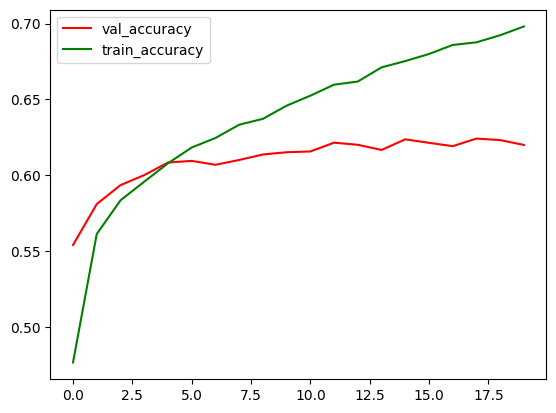

In [13]:
plt.plot(history.history['val_accuracy'],'r',label='val_accuracy')
plt.plot(history.history['accuracy'],'g',label='train_accuracy')
plt.legend()
plt.show()

Сравнение результатов конфигураций

Классификатор + итеративная разморозка + адаптивный lr

In [14]:
names_layers = ['block1_conv2', 'block2_conv2', 'block3_conv2', 'block4_conv2', 'block5_conv2']
lr_list = [0.0001, 0.001, 0.01, 0.1]

In [15]:
#Разморозка слоев в базовой модели
for layer in vgg19.layers:
  if layer.name == names_layers:
    layer.trainable = True

In [16]:
def unfreeze_layers(model, layers):
  for layer in vgg19.layers:
    if layer.name == names_layers:
      layer.trainable = True

In [17]:
unfreeze_layers(base_model, [3, 6, 9, 14, 19])
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate = lr_list[1])
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization (Batch  (None, 1, 1, 512)         2048      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 20160330 (76.91 MB)
Trainable params: 134922 (527.04 KB)
Non-trainable params: 20025408 (76.39 MB)
_________

In [18]:
base_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = base_model.fit(x_train, y_train10,
              epochs=20,
              validation_data=(x_test, y_test10),
              shuffle=True)
df_results_2.loc['Классификатор + итеративная разморозка + адаптивный lr'] = [history.history['accuracy'], history.history['val_accuracy']]

Epoch 1/20
1563/1563 [==============================] - 23s 14ms/step - loss: 0.8190 - accuracy: 0.7158 - val_loss: 1.1312 - val_accuracy: 0.6259
Epoch 2/20
1563/1563 [==============================] - 20s 13ms/step - loss: 0.8107 - accuracy: 0.7195 - val_loss: 1.1349 - val_accuracy: 0.6238
Epoch 3/20
1563/1563 [==============================] - 22s 14ms/step - loss: 0.8106 - accuracy: 0.7190 - val_loss: 1.1270 - val_accuracy: 0.6260
Epoch 4/20
1563/1563 [==============================] - 22s 14ms/step - loss: 0.8102 - accuracy: 0.7198 - val_loss: 1.1277 - val_accuracy: 0.6252
Epoch 5/20
1563/1563 [==============================] - 20s 13ms/step - loss: 0.8075 - accuracy: 0.7201 - val_loss: 1.1359 - val_accuracy: 0.6259
Epoch 6/20
1563/1563 [==============================] - 20s 13ms/step - loss: 0.8055 - accuracy: 0.7224 - val_loss: 1.1289 - val_accuracy: 0.6275
Epoch 7/20
1563/1563 [==============================] - 22s 14ms/step - loss: 0.8018 - accuracy: 0.7231 - val_loss: 1.1285 -

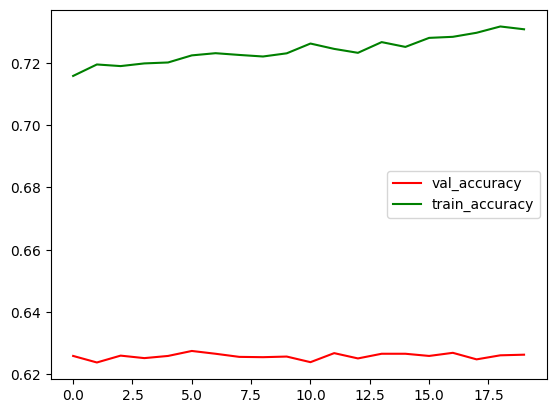

In [19]:
plt.plot(history.history['val_accuracy'],'r',label='val_accuracy')
plt.plot(history.history['accuracy'],'g',label='train_accuracy')
plt.legend()
plt.show()

Классификатор + итеративная аугментация

In [20]:
base_model = Sequential()
base_model.add(vgg19)
#Компиляция модели к последующему обучению
base_model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])
base_model.add(BatchNormalization())
base_model.add(Flatten()) # векторим вход
base_model.add(Dense(256,activation='relu'))
base_model.add(Dense(10,activation='softmax'))

In [21]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.,
        zoom_range=0.,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)
# запуск data augmentation через fit_generator
history = base_model.fit(datagen.flow(x_train, y_train10),
                        epochs=epochs,
                        validation_data=(x_test, y_test10),
                        workers=4)
df_results_2.loc['Классификатор + аугментация'] = [history.history['accuracy'], history.history['val_accuracy']]

Epoch 1/20
1563/1563 [==============================] - 53s 33ms/step - loss: 1.5835 - accuracy: 0.4476 - val_loss: 1.3364 - val_accuracy: 0.5470
Epoch 2/20
1563/1563 [==============================] - 51s 33ms/step - loss: 1.3401 - accuracy: 0.5313 - val_loss: 1.2653 - val_accuracy: 0.5723
Epoch 3/20
1563/1563 [==============================] - 51s 33ms/step - loss: 1.2924 - accuracy: 0.5467 - val_loss: 1.2351 - val_accuracy: 0.5811
Epoch 4/20
1563/1563 [==============================] - 50s 32ms/step - loss: 1.2574 - accuracy: 0.5583 - val_loss: 1.2049 - val_accuracy: 0.5869
Epoch 5/20
1563/1563 [==============================] - 52s 33ms/step - loss: 1.2326 - accuracy: 0.5642 - val_loss: 1.1904 - val_accuracy: 0.5939
Epoch 6/20
1563/1563 [==============================] - 50s 32ms/step - loss: 1.2129 - accuracy: 0.5748 - val_loss: 1.1833 - val_accuracy: 0.5973
Epoch 7/20
1563/1563 [==============================] - 48s 31ms/step - loss: 1.1993 - accuracy: 0.5800 - val_loss: 1.1702 -

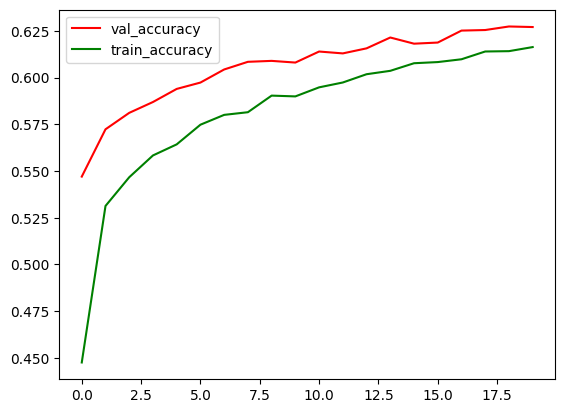

In [22]:
plt.plot(history.history['val_accuracy'],'r',label='val_accuracy')
plt.plot(history.history['accuracy'],'g',label='train_accuracy')
plt.legend()
plt.show()

Классификатор + все методы улучшения

In [38]:
unfreeze_layers(base_model, [3, 6, 9, 14, 19])
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate = lr_list[0])
base_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = base_model.fit(x_train, y_train10,
              epochs=10,
              validation_data=(x_test, y_test10),
              shuffle=True)
df_results_2.loc['Классификатор + все методы'] = [history.history['accuracy'], history.history['val_accuracy']]

Epoch 1/10
1563/1563 [==============================] - 23s 14ms/step - loss: 0.8048 - accuracy: 0.6568 - val_loss: 0.7478 - val_accuracy: 0.6157
Epoch 2/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.6659 - accuracy: 0.6555 - val_loss: 0.6244 - val_accuracy: 0.6144
Epoch 3/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.5599 - accuracy: 0.6547 - val_loss: 0.5314 - val_accuracy: 0.6125
Epoch 4/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.4808 - accuracy: 0.6547 - val_loss: 0.4626 - val_accuracy: 0.6102
Epoch 5/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.4196 - accuracy: 0.6553 - val_loss: 0.4086 - val_accuracy: 0.6105
Epoch 6/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.3728 - accuracy: 0.6534 - val_loss: 0.3667 - val_accuracy: 0.6076
Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.3372 - accuracy: 0.6538 - val_loss: 0.3359 -

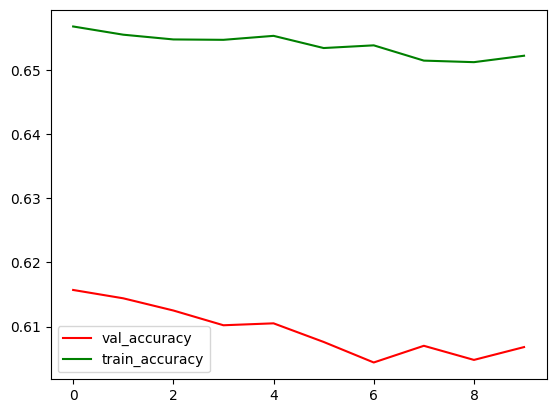

In [39]:
plt.plot(history.history['val_accuracy'],'r',label='val_accuracy')
plt.plot(history.history['accuracy'],'g',label='train_accuracy')
plt.legend()
plt.show()

In [28]:
df_results_2

,accuracy,val_accuracy
Чистый классификатор,"[0.47655999660491943, 0.5612599849700928, 0.58...","[0.5540000200271606, 0.5809999704360962, 0.593..."
Классификатор + итеративная разморозка + адаптивный lr,"[0.7158200144767761, 0.7195000052452087, 0.718...","[0.6258999705314636, 0.6237999796867371, 0.625..."
Классификатор + аугментация,"[0.4475800096988678, 0.5313000082969666, 0.546...","[0.546999990940094, 0.5723000168800354, 0.5810..."


Лучший результат показала конфигурация модели "Классификатор + итеративная разморозка + адаптивный lr" 73%, что значительно лучше базового классификатора (на 15 %). Худший результат показала конфигурация модели "Классификатор + все возможные улучшения".


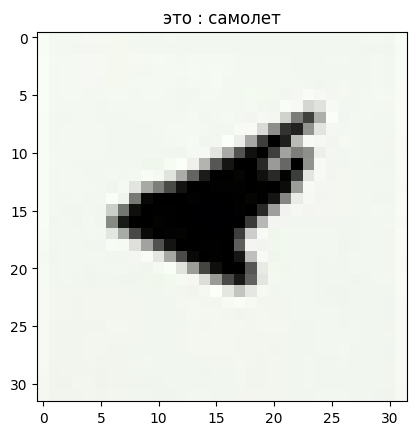

In [ ]:
N = 21
plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[np.argmax(y_test[N,:])])
plt.show()

# Псевдолейблинг

In [ ]:
import numpy as np, pandas as pd, os
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import utils

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.datasets import cifar10

In [ ]:
# Количество классов изображений
nb_classes = 10
# Названия классов из набора данных CIFAR-10
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train10 = utils.to_categorical(y_train, nb_classes)
y_test10 = utils.to_categorical(y_test, nb_classes)
# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [ ]:
#Набор для псевдолейблинга из 1000 экземпляров (всего в тестовом 10000, берем 10%)
x_test_2 = x_test[0:1000]

In [ ]:
print('x_test shape:', x_test.shape)
print('x_test_2 shape:', x_test_2.shape)

x_test shape: (10000, 32, 32, 3)
x_test_2 shape: (1000, 32, 32, 3)


In [ ]:
y_test_4 = []

In [ ]:
#Предсказание модели для новой выборки
for i in x_test_2:
  pred = np.argmax(base_model.predict(i[None, ...])[0, ...])
  y_test_4.append([pred])

In [ ]:
y_train_4_10 = utils.to_categorical(y_test_4, nb_classes)

In [ ]:
x_train_final = np.vstack([x_train, x_test_2])

In [ ]:
y_train_final_10 = np.vstack([y_train10, y_train_4_10])

In [ ]:
print('x_train_final:', x_train_final.shape)
print('y_train_final:', y_train_final_10.shape)

x_train_final: (51000, 32, 32, 3)
y_train_final: (51000, 10)


In [ ]:
#Обучение лучшей конфигурации модели на увеличенном наборе данных
history = base_model.fit(x_train_final, y_train_final_10,
              epochs=20,
              validation_data=(x_test, y_test10),
              shuffle=True)

Epoch 1/20
1594/1594 [==============================] - 22s 14ms/step - loss: 0.7874 - accuracy: 0.7275 - val_loss: 1.1380 - val_accuracy: 0.6236
Epoch 2/20
1594/1594 [==============================] - 19s 12ms/step - loss: 0.7845 - accuracy: 0.7278 - val_loss: 1.1358 - val_accuracy: 0.6245
Epoch 3/20
1594/1594 [==============================] - 19s 12ms/step - loss: 0.7781 - accuracy: 0.7284 - val_loss: 1.1321 - val_accuracy: 0.6255
Epoch 4/20
1594/1594 [==============================] - 20s 12ms/step - loss: 0.7856 - accuracy: 0.7271 - val_loss: 1.1370 - val_accuracy: 0.6264
Epoch 5/20
1594/1594 [==============================] - 22s 14ms/step - loss: 0.7800 - accuracy: 0.7284 - val_loss: 1.1316 - val_accuracy: 0.6244
Epoch 6/20
1594/1594 [==============================] - 23s 14ms/step - loss: 0.7742 - accuracy: 0.7328 - val_loss: 1.1373 - val_accuracy: 0.6248
Epoch 7/20
1594/1594 [==============================] - 26s 17ms/step - loss: 0.7728 - accuracy: 0.7323 - val_loss: 1.1369 -

In [ ]:
df_results_2.loc['Псевдолейблинг_10%'] = [history.history['accuracy'], history.history['val_accuracy']]

In [ ]:
df_results_2

,accuracy,val_accuracy
Классификатор + итеративная разморозка + адаптивный lr,"[0.7132400274276733, 0.7131800055503845, 0.717...","[0.6255999803543091, 0.6233999729156494, 0.622..."
Псевдолейблинг_10%,"[0.727450966835022, 0.7277843356132507, 0.7284...","[0.6236000061035156, 0.6244999766349792, 0.625..."


На сравнительно небольшом количестве данных, добавленных посредством псевдолейблинга (в исходном тренировочном наборе было 50 000 экземпляров, добавили 10 % от тестового набора, т.е. 1 000 экземпляров), модель показала значительное улучшение результата - на 1%.

Попробуем задействовать 30% тестового датасета для псевдолейблинга и замерим результат работы модели.

In [ ]:
#Набор для псевдолейблинга из 3 000 экземпляров (всего в тестовом 10000, берем 30%)
x_test_30 = x_test[0:3000]

In [ ]:
print('x_test shape:', x_test.shape)
print('x_test_30 shape:', x_test_30.shape)

x_test shape: (10000, 32, 32, 3)
x_test_30 shape: (3000, 32, 32, 3)


In [ ]:
y_test_30 = []

In [ ]:
#Предсказание модели для новой выборки
for i in x_test_30:
  pred = np.argmax(base_model.predict(i[None, ...])[0, ...])
  y_test_30.append([pred])

In [ ]:
y_train_30_10 = utils.to_categorical(y_test_30, nb_classes)

In [ ]:
x_train_final_30 = np.vstack([x_train, x_test_30])
y_train_final_30_10 = np.vstack([y_train10, y_train_30_10])
print('x_train_final:', x_train_final_30.shape)
print('y_train_final:', y_train_final_30_10.shape)

x_train_final: (53000, 32, 32, 3)
y_train_final: (53000, 10)


In [ ]:
#Обучение лучшей конфигурации модели на увеличенном наборе данных
history = base_model.fit(x_train_final_30, y_train_final_30_10,
              epochs=20,
              validation_data=(x_test, y_test10),
              shuffle=True)

Epoch 1/20
1657/1657 [==============================] - 23s 14ms/step - loss: 0.7468 - accuracy: 0.7412 - val_loss: 1.1505 - val_accuracy: 0.6236
Epoch 2/20
1657/1657 [==============================] - 22s 13ms/step - loss: 0.7457 - accuracy: 0.7409 - val_loss: 1.1487 - val_accuracy: 0.6246
Epoch 3/20
1657/1657 [==============================] - 22s 13ms/step - loss: 0.7441 - accuracy: 0.7408 - val_loss: 1.1485 - val_accuracy: 0.6235
Epoch 4/20
1657/1657 [==============================] - 22s 13ms/step - loss: 0.7411 - accuracy: 0.7445 - val_loss: 1.1502 - val_accuracy: 0.6266
Epoch 5/20
1657/1657 [==============================] - 20s 12ms/step - loss: 0.7382 - accuracy: 0.7449 - val_loss: 1.1639 - val_accuracy: 0.6230
Epoch 6/20
1657/1657 [==============================] - 20s 12ms/step - loss: 0.7413 - accuracy: 0.7426 - val_loss: 1.1800 - val_accuracy: 0.6225
Epoch 7/20
1657/1657 [==============================] - 23s 14ms/step - loss: 0.7357 - accuracy: 0.7452 - val_loss: 1.1612 -

In [ ]:
df_results_2.loc['Псевдолейблинг_30%'] = [history.history['accuracy'], history.history['val_accuracy']]
df_results_2

,accuracy,val_accuracy
Классификатор + итеративная разморозка + адаптивный lr,"[0.7132400274276733, 0.7131800055503845, 0.717...","[0.6255999803543091, 0.6233999729156494, 0.622..."
Псевдолейблинг_10%,"[0.727450966835022, 0.7277843356132507, 0.7284...","[0.6236000061035156, 0.6244999766349792, 0.625..."
Псевдолейблинг_30%,"[0.7411887049674988, 0.7408679127693176, 0.740...","[0.6236000061035156, 0.6245999932289124, 0.623..."


На большом количестве данных, добавленных посредством псевдолейблинга (30 % от тестового набора данных (в исходном тренировочном наборе было 50 000 экземпляров, добавили 3 000 экземпляров), модель показала значительно лучшее качество. Правильность ответов модели увеличилась на 2% от лучшей конфигурации, и на 1% относительно псевдолейблинга на 10% от тестового сета. Это очень хорошее улучшение результата, но 30% от тестового сета для использования псевдолейблинга это много.

**Задание №2**

**Придумать 3 отличающихся от рассказанных на занятии метрики качества поиска (во всем многообразии элементов поисковой выдачи) и объяснить, почему их можно брать в качестве основных для оценки качества.**



CTR@N — отношение количества выдач, в которых был хотя бы один клик в первые N позиций в выдаче, к количеству всех выдач, измеряется в процентах.
Чем выше CTR, тем лучше.

В ряде случаев (например, новостная выдача), важен такой показатель как новизна. Эта метрика позволяет определить, насколько результаты поиска являются актуальными и свежими. Чем больше новизна, тем лучше.

Среднее время ответа (Average Response Time): Эта метрика измеряет время, затраченное на получение результатов поиска. Чем меньше среднее время ответа, тем быстрее пользователь получает результаты и тем лучше качество поиска.

**Задание №3**

**Придумать 3 отличающихся от рассказанных на занятии метода улучшения качества разметки релевантности и объяснить, как именно они улучшат качество.**

Анализ социальных сетей. Позволяет системе поиска анализировать активность пользователей в социальных сетях и определять, какие страницы являются наиболее релевантными для конкретного запроса. Например, система может анализировать количество лайков и комментариев на странице и использовать их для определения релевантности. Это позволит системе более точно определять релевантность страниц и улучшать качество разметки релевантности.

Использование анализа поведения пользователей. Позволяет системе поиска анализировать поведение пользователей на сайте и определять, какие страницы являются наиболее релевантными для конкретного запроса. Например, система может анализировать время, проведенное пользователем на странице, и использовать его для определения релевантности. Это позволит системе более точно определять релевантность страниц и улучшать качество разметки релевантности.

Использование анализа изображений. Позволяет системе поиска анализировать изображения на страницах и определять, какие страницы являются наиболее релевантными для конкретного запроса. Например, система может анализировать изображения на странице и использовать их для определения релевантности. Это позволит системе более точно определять релевантность страниц и улучшать качество разметки релевантности.

**Задание №4**

**Рассчитать p-value гипотезы "выдача google по запросу <выберите любой запрос> статистически значимо лучше, чем выдача yandex по этому же запросу". Оценку релевантности всех страниц выдачи, а также уровень значимости (порог, при котором мы отвергаем гипотезу) провести самостоятельно.**



In [ ]:
import scipy.stats as stats

In [ ]:
# Оценка релевантности выдачи поисковиков по запросу
google_relevance = [3, 4, 2, 5, 4, 3, 2, 5, 3]
yandex_relevance = [2, 3, 1, 4, 3, 2, 1, 4, 2]

Установим уровень значимости 0,05.

In [ ]:
p = 0.05

Проверяем гипотезу

In [ ]:
p_value = stats.mannwhitneyu(google_relevance, yandex_relevance, alternative='greater')[1]
p_value

0.0511416764811998

In [ ]:
if abs(p) > p_value:
    print("Мы можем отвергнуть нулевую гипотезу!")
else:
    print("Не удалось отвергнуть нулевую гипотезу")

Не удалось отвергнуть нулевую гипотезу


Соответственно, выдача google по запросу статистически значимо лучше, чем выдача yandex по этому же запросу.